In [1]:
import numpy as np 
import csv
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from lib.nn import*
from lib.plot import *
import pickle


c:\Users\Wei_L\anaconda3\envs\doe\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load training data and normalize the data 

In [2]:
# datatype = 'field'
datatype = 'random'
if datatype == 'field':
    data = np.load('data_pred/sim_field.npy')
elif datatype == 'random':
    data = np.load('data_pred/sim_random.npy')
else:
    print('wrong datatype')

scaler = pickle.load(open('scaler.pkl','rb'))
datan = scaler.transform(data)
trainlen = 8500
train = datan[:trainlen,:]
test = datan[trainlen:,:]

# Train NN model

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
net = Net().to(device)    # transfer model to GPU if available
Train= 0
if Train == True:
    net.train()   # set model in train mode (eg batchnorm params get updated)
    opt = optim.Adam(net.parameters(), lr=0.001)       # create optimizer instance
    criterion = nn.MSELoss() 
    for i in range(20):
        model_path = './data_pred/nnhistory_{}/'.format(datatype)
        if not os.path.exists(model_path):
            # If it doesn't exist, create it
            os.makedirs(model_path)
        train_it = 0
        best_loss = 100
        batch_size = 256
        epochs = 200
        val_loss = []
        rec_loss = []
        vallen = int(trainlen*0.7)

        for ep in range(epochs):
  
            np.random.seed(int(time.time()))
            trainl = np.arange(len(train))
            np.random.shuffle(trainl)
            int(trainlen*0.7)
            traintemp = train[trainl[:vallen],:] 
            val = train[trainl[vallen:],:] 
            val = torch.from_numpy(val)
            traintemp = torch.from_numpy(traintemp)
            print("Run Epoch {}".format(ep))

            Trains = torch.utils.data.DataLoader(traintemp,batch_size=batch_size)    

            for Train in Trains:
                train_x = Train[:,:5]
                train_y = Train[:,5:]
                opt.zero_grad()
                outputs = net(train_x)
                # loss
                total_loss = criterion(outputs, train_y)

                # backward
                total_loss.backward()
                # update the weights
                opt.step()

                if train_it % 1000 == 0:
                    print("It {}: Reconstruction Loss: {}".format(train_it, total_loss))
                train_it += 1


            val_output = net(val[:,:5]) 
            val_loss1 = criterion(val_output,val[:,5:])
            val_loss.append(val_loss1)
            train_output = net(traintemp[:,:5])
            total_loss = criterion(train_output, traintemp[:,5:])
            rec_loss.append(total_loss)

            print("It {}: Validation Loss: {}".format(ep, val_loss1))

            if val_loss1 < best_loss:
                torch.save(net.state_dict(), '{}/model{}.pth'.format(model_path,i))
                best_loss = val_loss1


In [35]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

for i in range(20):
    X, y = shuffle(train[:,:5], train[:,5:], random_state=i)
    print(X[:5,:])
    # Split the data
    trainx, valx, trainy, valy = train_test_split(X, y, test_size=0.3, random_state=i)
    
    lr_model = MultiOutputRegressor(LinearRegression())
    lr_model.fit(trainx, trainy)
    # Create and fit the MultiOutput Support Vector Regression (SVR) model
    svr_model = MultiOutputRegressor(SVR(kernel='linear'))  # You can choose different kernels as per your data
    svr_model.fit(trainx, trainy)
    
    ## nonlinearity
    svr_model2 = MultiOutputRegressor(SVR(kernel='rbf'))  # You can choose different kernels as per your data
    svr_model2.fit(trainx, trainy)
    
    ## save lr model

    model_path = './data_pred/LRhistory_{}'.format(datatype)
    if not os.path.exists(model_path):
    # If it doesn't exist, create it
        os.makedirs(model_path)
    model_filename = '{}/lr_model{}.pkl'.format(model_path,i)  # You can choose any file name and extension
    with open(model_filename, 'wb') as model_file:
        pickle.dump(lr_model, model_file)
    ##################------------------------------------##################
    # save svr model
    model_path = './data_pred/SVM_L_history_{}'.format(datatype)
    if not os.path.exists(model_path):
    # If it doesn't exist, create it
        os.makedirs(model_path)
    model_filename = '{}/SVM_model{}.pkl'.format(model_path,i)  # You can choose any file name and extension
    with open(model_filename, 'wb') as model_file:
        pickle.dump(svr_model, model_file)
    ##################------------------------------------##################
    # save svr2 model
    model_path = './data_pred/SVM_N_history_{}'.format(datatype)
    if not os.path.exists(model_path):
    # If it doesn't exist, create it
        os.makedirs(model_path)
    model_filename = '{}/SVM_N_model{}.pkl'.format(model_path,i)  # You can choose any file name and extension
    with open(model_filename, 'wb') as model_file:
        pickle.dump(svr_model2, model_file)


[[0.2606324  0.61156845 0.5310892  0.74489796 0.6562176 ]
 [0.25845134 0.76859283 0.6384196  0.8746356  0.7659359 ]
 [0.28898573 0.5785103  0.4751755  0.6763848  0.22988558]
 [0.1755724  0.603302   0.33168703 0.60641396 0.34796286]
 [0.28462362 0.76859283 0.6984664  0.819242   0.83699083]]
[[0.17775345 0.57024384 0.33168703 0.60641396 0.66353226]
 [0.17775345 0.5867729  0.32986742 0.79591835 0.541275  ]
 [0.17230093 0.5867729  0.33038735 0.6297376  0.2727275 ]
 [0.26717544 0.76859283 0.6472577  0.88483965 0.89341736]
 [0.17666304 0.55371857 0.32856774 0.78717196 0.28631163]]
[[0.25299883 0.52892303 0.68235004 0.8746356  0.39916468]
 [0.27699018 0.75206375 0.6702626  0.7798834  0.30512047]
 [0.20065427 0.73553085 0.340837   0.7172011  0.34796286]
 [0.22137403 0.66941833 0.33813363 0.7172011  0.50365734]
 [0.5561613  0.7768593  0.9802444  0.8746356  0.98955107]]
[[0.2562704  0.8264427  0.69170785 0.8294461  0.8693838 ]
 [0.17230093 0.5371895  0.32856774 0.79591835 0.3082552 ]
 [0.2660850

# load two dataset
For testing the data importance when training the model, we use two testing set and evaluate the results from the model trained by different dataset(named 'random','field'). The RMSE and MAPE will be summarize in the excel 


In [37]:
datatype = 'random'
data = np.load('data_pred/sim_random.npy')
scaler = pickle.load(open('scaler.pkl','rb'))
datan = scaler.transform(data)
trainlen = 8500
train = datan[:trainlen,:]
test_random = datan[trainlen:,:]

datatype = 'field'
data = np.load('data_pred/sim_field.npy')
scaler = pickle.load(open('scaler.pkl','rb'))
datan2 = scaler.transform(data)
trainlen = 8500
train = datan2[:trainlen,:]
test_field = datan2[trainlen:,:]


## check prediction result of NN model

In [6]:
def recover(data):
    temp = np.ones_like(test_random)
    temp[:,5:] = data
    output = scaler.inverse_transform(temp)
    return output[:,5:]
RMSE_NN_field = []
RMSE_NN_random = []
MAPE_NN_random = []
MAPE_NN_field = []
for i in range(20):
    model_path = './data_pred/nnhistory_random/'
    net_eval = Net().to(device)
    net_eval.load_state_dict(torch.load('{}/model{}.pth'.format(model_path,i)))
    net_eval.eval() 
    testy_random = test_random[:,5:]
    testy_field = test_field[:,5:]
    pred_random = net_eval(torch.from_numpy(test_random[:,:5])).detach().numpy()
    pred_field = net_eval(torch.from_numpy(test_field[:,:5])).detach().numpy()

    # calculate rmse 
    rmse_random = np.round(np.sqrt(np.mean((pred_random - testy_random)**2,axis =0)),3)
    rmse_field = np.round(np.sqrt(np.mean((pred_field - testy_field)**2,axis =0)),3)
    # recover it to original scale
    # testy_random_ = recover(testy_random)
    # testy_field_ = recover(testy_field)
    # pred_random_ = recover(pred_random)
    # pred_field_ = recover(pred_field)

    # calculate mape

    temp_random = np.ma.masked_invalid(np.abs(pred_random-testy_random)/testy_random)
    temp_field = np.ma.masked_invalid(np.abs(pred_field-testy_field)/testy_field)
    # temp_random = np.ma.masked_invalid(np.abs(pred_random_-testy_random_)/testy_random_)
    # temp_field = np.ma.masked_invalid(np.abs(pred_field_-testy_field_)/testy_field_)
    mape_random = np.round(np.mean(temp_random,axis =0),3)*100
    mape_field = np.round(np.mean(temp_field,axis =0),3)*100

    RMSE_NN_random.append(rmse_random)
    RMSE_NN_field.append(rmse_field)
    MAPE_NN_random.append(mape_random)
    MAPE_NN_field.append(mape_field)

print('RMSE_NN_random',np.round(np.mean(RMSE_NN_random,axis = 0),3),np.round(np.std(RMSE_NN_random,axis = 0),3))
print('RMSE_NN_field',np.round(np.mean(RMSE_NN_field,axis = 0),3),np.round(np.std(RMSE_NN_field,axis = 0),3))
print('MAPE_NN_random',np.round(np.mean(MAPE_NN_random,axis = 0),3),np.round(np.std(MAPE_NN_random,axis = 0),3))
print('MAPE_NN_field',np.round(np.mean(MAPE_NN_field,axis = 0),3),np.round(np.std(MAPE_NN_field,axis = 0),3))


RMSE_NN_random [0.013 0.01 ] [0.001 0.001]
RMSE_NN_field [0.01  0.008] [0.002 0.002]
MAPE_NN_random [1.58 0.66] [0.218 0.229]
MAPE_NN_field [2.055 1.02 ] [0.397 0.308]


## Check LR SVRs results

In [38]:
def check_results(model_path,model_type):
    # model_file = None
    RMSE_field = []
    RMSE_random = []
    MAPE_random = []
    MAPE_field = []

    for i in range(20):

        model_filename = '{}/{}_model{}.pkl'.format(model_path,model_type,i)
        # print(model_file)
        with open(model_filename, 'rb') as model_file:
            loaded_model = pickle.load(model_file)
        pred_random = loaded_model.predict(test_random[:,:5])
        pred_field = loaded_model.predict(test_field[:,:5])

        for idx, estimator in enumerate(loaded_model.estimators_):
            print(f"Estimator {idx} coefficients:", estimator.coef_)
            print(f"Estimator {idx} intercept:", estimator.intercept_)
        testy_random = test_random[:,5:]
        testy_field = test_field[:,5:]


        # calculate rmse 
        rmse_random = np.round(np.sqrt(np.mean((pred_random - testy_random)**2,axis =0)),3)
        rmse_field = np.round(np.sqrt(np.mean((pred_field - testy_field)**2,axis =0)),3)
        # recover it to original scale
        # testy_random_ = recover(testy_random)
        # testy_field_ = recover(testy_field)
        # pred_random_ = recover(pred_random)
        # pred_field_ = recover(pred_field)

        # calculate mape

        temp_random = np.ma.masked_invalid(np.abs(pred_random-testy_random)/testy_random)
        temp_field = np.ma.masked_invalid(np.abs(pred_field-testy_field)/testy_field)
        # temp_random = np.ma.masked_invalid(np.abs(pred_random_-testy_random_)/testy_random_)
        # temp_field = np.ma.masked_invalid(np.abs(pred_field_-testy_field_)/testy_field_)
        mape_random = np.round(np.mean(temp_random,axis =0),3)*100
        mape_field = np.round(np.mean(temp_field,axis =0),3)*100

        RMSE_random.append(rmse_random)
        RMSE_field.append(rmse_field)
        MAPE_random.append(mape_random)
        MAPE_field.append(mape_field)
    
    print("Model: {}".format(model_type))
    print('RMSE_random',np.round(np.mean(RMSE_random,axis = 0),3),np.round(np.std(RMSE_random,axis = 0),3))
    print('RMSE_field',np.round(np.mean(RMSE_field,axis = 0),3),np.round(np.std(RMSE_field,axis = 0),3))
    print('MAPE_random',np.round(np.mean(MAPE_NN_random,axis = 0),3),np.round(np.std(MAPE_random,axis = 0),3))
    print('MAPE_field',np.round(np.mean(MAPE_NN_field,axis = 0),3),np.round(np.std(MAPE_field,axis = 0),3))   
    print("-------------------------------------------")

    return pred_random,pred_field,RMSE_random,RMSE_field,MAPE_random,MAPE_field 

In [34]:
pred_lr_random,pred_lr_field,RMSE_lr_random,RMSE_lr_field,MAPE_lr_random,MAPE_lr_field = check_results('./data_pred/LRhistory_random','lr')
pred_svm_random,pred_svm_field,RMSE_svm_random,RMSE_svm_field,MAPE_svm_random,MAPE_svm_field = check_results('./data_pred/SVM_L_history_random','SVM')
pred_svm_random2,pred_svm_field2,RMSE_svm_random2,RMSE_svm_field2,MAPE_svm_random2,MAPE_svm_field2 = check_results('./data_pred/SVM_N_history_random','SVM_N')



Estimator 0 coefficients: [-0.17134634  0.12251401  0.6178723   0.41570413 -0.9130515 ]
Estimator 0 intercept: 0.3108353
Estimator 1 coefficients: [-0.02791367 -0.00522067  0.01849065  1.2608759  -0.21369737]
Estimator 1 intercept: -0.21787483
Estimator 0 coefficients: [-0.17051934  0.10419255  0.7571439   0.3613547  -0.8486624 ]
Estimator 0 intercept: 0.26507044
Estimator 1 coefficients: [ 0.02236727  0.04534829  0.01253554  1.2437229  -0.19876401]
Estimator 1 intercept: -0.25232387
Estimator 0 coefficients: [ 0.09705885  0.04773411  0.6827004   0.3716302  -0.91988826]
Estimator 0 intercept: 0.31964475
Estimator 1 coefficients: [-0.00970314  0.02241278 -0.00452545  1.2623265  -0.21677865]
Estimator 1 intercept: -0.23157293
Estimator 0 coefficients: [-0.01604341  0.07833576  0.7267381   0.35924128 -0.8757652 ]
Estimator 0 intercept: 0.2844964
Estimator 1 coefficients: [-4.2072501e-02  5.4460764e-04  4.2417645e-03  1.2646688e+00
 -2.1615522e-01]
Estimator 1 intercept: -0.21429247
Estima

In [9]:
model_file
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

d:\USC_google_drive\DOE project\ORC_single_unit_revision


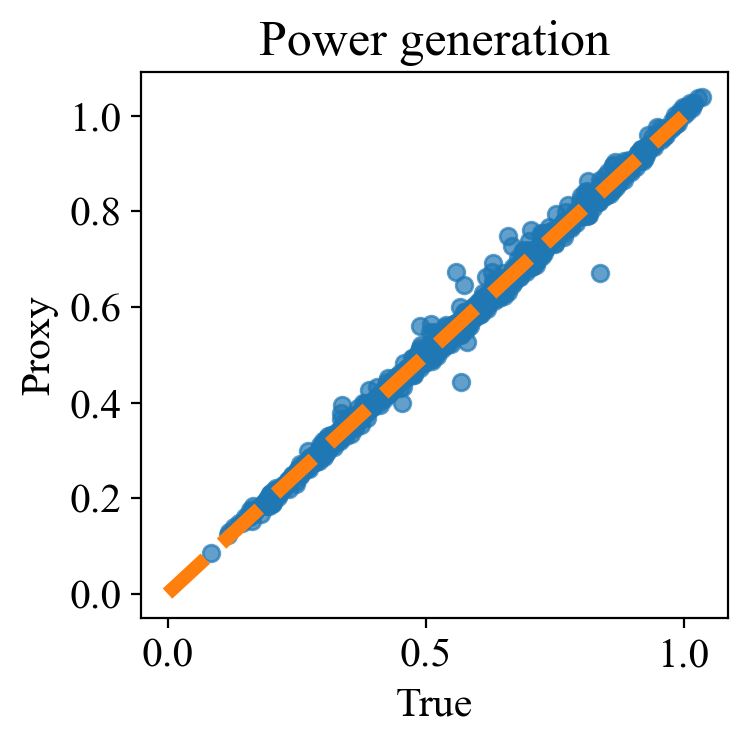

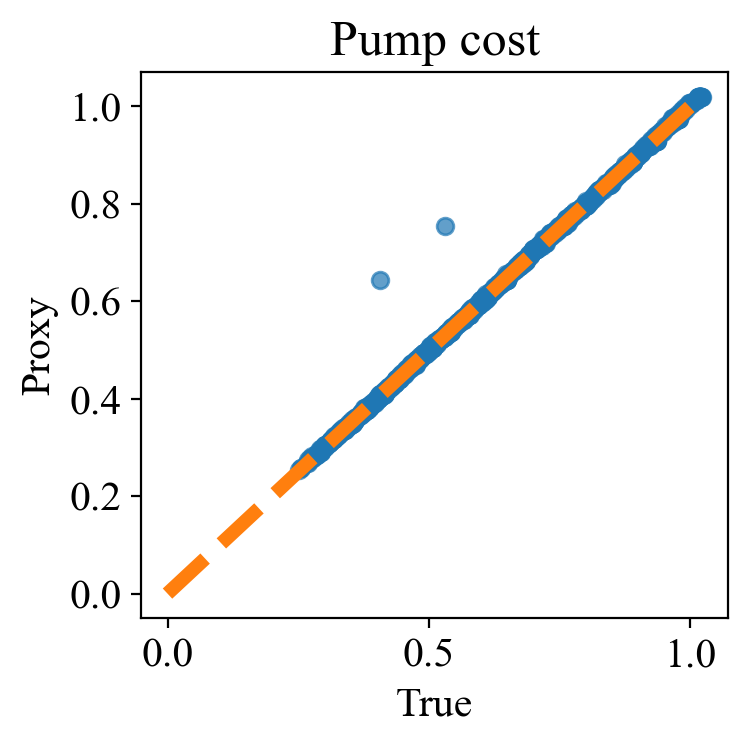

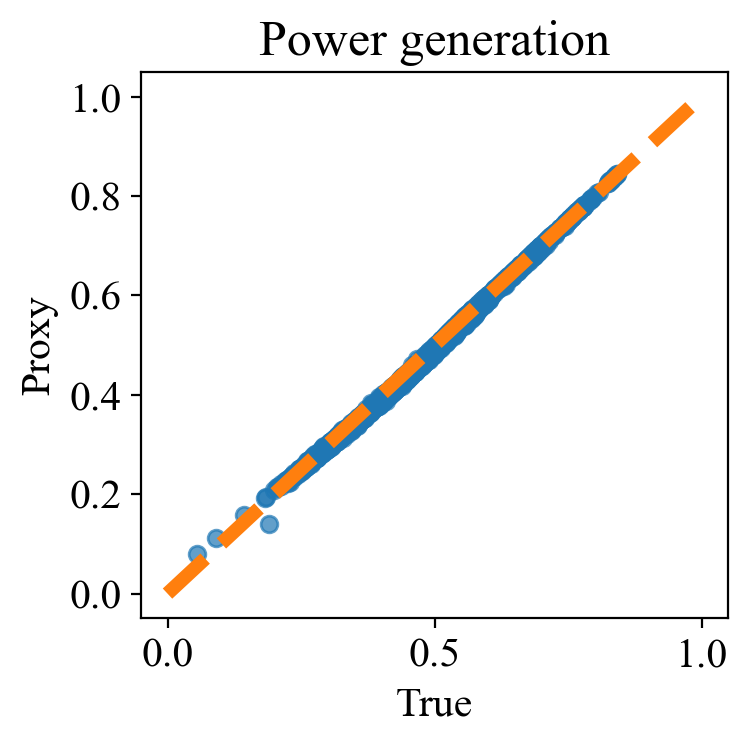

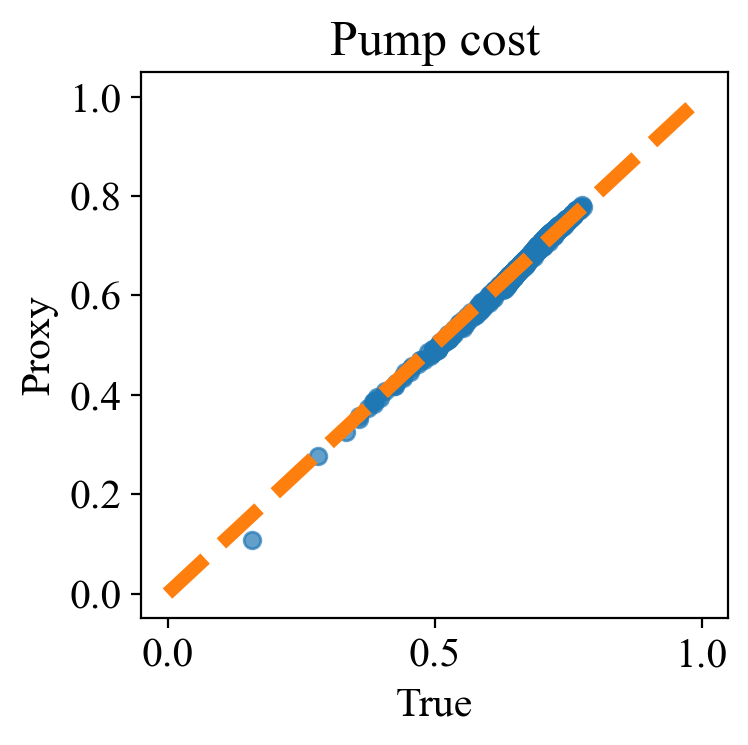

In [10]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = '15'
plt.rcParams["font.family"] = "Times New Roman"
def plot_pred(data, pred):
    plt.figure(figsize = (4,4))
    plt.scatter(data[:,0],pred[:,0],alpha = 0.7)
    plt.plot([0, 1], [0, 1], ls="--",linewidth = 5, color = 'tab:orange')

    plt.xlabel('True')
    plt.ylabel('Proxy')
    plt.title('Power generation')
    plt.tight_layout()
    # plt.savefig("./result/exp1-1.svg", bbox_inches='tight',dpi = 300)
    plt.show()


    plt.figure(figsize = (4,4))
    plt.scatter(data[:,1],pred[:,1],alpha = 0.7)
    plt.plot([0, 1], [0, 1], ls="--",linewidth = 5, color = 'tab:orange')
    plt.xlabel('True')
    plt.ylabel('Proxy')
    plt.title('Pump cost')
    plt.tight_layout()
    # plt.savefig("./result/exp1-2.svg", bbox_inches='tight',dpi = 300)
    plt.show()

plot_pred(pred_random,testy_random)
plot_pred(pred_field,testy_field)